<a href="https://colab.research.google.com/github/ArulselvanMadhavan/CSC508/blob/main/A_Student_Notebook_Covid_DT_RF_GBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Machine Learning Analysis Notebook

Welcome students to our COVID-19 Data Machine Learning Analysis Notebook!

In this notebook we will be analyzing a COVID-19 dataset using these three models:


1.   Decision Tree Regressor
2.   Random Forest Regressor
3.   Gradient Boosted Tree Regressor

## Import Necessary Libraries

In [1]:
# Data Wrangling Imports
import pandas as pd
import numpy as np
from google.colab import drive

# Machine Learning Models Imports
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Model Evaluation Imports and Visualization
from sklearn import metrics 
from matplotlib import pyplot as plt
import graphviz
from sklearn import tree
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import math

## Prepare the Data

First we must access our data from Github. The Github repository containing all of the raw datasets can be accessed using this link:     

https://github.com/ofaye98/CSC508_Mentor_Class


Raw Data was provided from these websites:           


*   Covid cases data (California Health and Human Services Agency) - https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a 

*   Covid vaccination data (Los Angeles Times) - https://github.com/datadesk/california-coronavirus-data 

*   Unemployment data (California Employment Development Dept.) - https://data.edd.ca.gov/Labor-Force-and-Unemployment-Rates/Local-Area-Unemployment-StatisticsdecisionLAUS-/e6gw-gvii 

*   Election data (Harvard University) - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ







In [2]:
# read csv as dataframe
data_url = "https://raw.githubusercontent.com/ofaye98/CSC508_Mentor_Class/main/FINAL_covid_unemployment_election_merged.csv" 
data = pd.read_csv(data_url)

In [3]:
# view the dataframe
data.head()

,county,population,fall_2020_cases,fall_2021_cases,spring_2020_cases,spring_2021_cases,summer_2020_cases,summer_2021_cases,winter_2020_cases,winter_2021_cases,fall_2020_doses_administered,fall_2021_doses_administered,spring_2021_doses_administered,summer_2020_doses_administered,summer_2021_doses_administered,winter_2020_doses_administered,winter_2021_doses_administered,fall_2020_pfizer_doses,fall_2021_pfizer_doses,spring_2021_pfizer_doses,summer_2020_pfizer_doses,summer_2021_pfizer_doses,winter_2020_pfizer_doses,winter_2021_pfizer_doses,fall_2020_moderna_doses,fall_2021_moderna_doses,spring_2021_moderna_doses,summer_2020_moderna_doses,summer_2021_moderna_doses,winter_2020_moderna_doses,winter_2021_moderna_doses,fall_2020_jj_doses,fall_2021_jj_doses,spring_2021_jj_doses,summer_2020_jj_doses,summer_2021_jj_doses,winter_2020_jj_doses,winter_2021_jj_doses,fall_2020_partially_vaccinated,fall_2021_partially_vaccinated,...,fall_2021_fully_vaccinated,spring_2021_fully_vaccinated,summer_2020_fully_vaccinated,summer_2021_fully_vaccinated,winter_2020_fully_vaccinated,winter_2021_fully_vaccinated,fall_2020_partially_vaccinated_percent,fall_2021_partially_vaccinated_percent,spring_2021_partially_vaccinated_percent,summer_2020_partially_vaccinated_percent,summer_2021_partially_vaccinated_percent,winter_2020_partially_vaccinated_percent,winter_2021_partially_vaccinated_percent,fall_2020_at_least_one_dose_percent,fall_2021_at_least_one_dose_percent,spring_2021_at_least_one_dose_percent,summer_2020_at_least_one_dose_percent,summer_2021_at_least_one_dose_percent,winter_2020_at_least_one_dose_percent,winter_2021_at_least_one_dose_percent,fall_2020_fully_vaccinated_percent,fall_2021_fully_vaccinated_percent,spring_2021_fully_vaccinated_percent,summer_2020_fully_vaccinated_percent,summer_2021_fully_vaccinated_percent,winter_2020_fully_vaccinated_percent,winter_2021_fully_vaccinated_percent,spring_2020_Unemployment_Rate,spring_2021_Unemployment_Rate,summer_2020_Unemployment_Rate,summer_2021_Unemployment_Rate,fall_2020_Unemployment_Rate,fall_2021_Unemployment_Rate,winter_2020_Unemployment_Rate,winter_2021_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent
0,Alameda,1685886,11054,2601,5161,5862,14483,23141,23533,27339,17,277728,1132830,78,258266,23688,955341,10,193426,725685,74,204507,16671,580841,3,78527,327129,4,44793,7003,349068,4,5759,79829,0,8898,10,25286,9,46894,...,31879,656370,37,115788,61,406277,0.000006,0.059119,0.180871,0.000016,0.055480,0.014345,0.141542,0.000033,0.795518,0.698430,0.000026,0.765296,0.014409,0.362575,0.000027,0.736399,0.646561,0.000023,0.717004,0.000064,0.247236,0.138521,0.062728,0.119655,0.064572,0.084277,0.052409,0.031265,0.069809,0.802082,0.006057,0.177009,0.008175,0.006679
1,Alpine,1117,51,3,1,3,2,13,15,16,0,111,525,0,72,21,921,0,10,15,0,10,5,19,0,101,507,0,62,16,900,0,0,3,0,0,0,2,0,17,...,9,393,0,7,0,296,0.000000,0.092334,0.297909,0.000000,0.085366,0.018293,0.310976,0.000000,0.706446,0.672474,0.000000,0.691638,0.018293,0.556620,0.000000,0.614111,0.600174,0.000000,0.606272,0.000000,0.257840,0.222222,0.081967,0.152174,0.085106,0.108696,0.083333,0.047619,0.071429,0.642375,0.005398,0.329285,0.020243,0.002699
2,Amador,38531,574,233,26,182,266,1319,1840,868,1,5264,12876,0,4960,601,21483,1,1742,3280,0,2686,507,5212,0,3382,8872,0,1875,94,15882,0,140,722,0,399,0,389,1,848,...,759,7949,0,2199,3,8316,0.000026,0.087367,0.136165,0.000000,0.088794,0.015438,0.149991,0.000026,0.595601,0.500013,0.000000,0.570673,0.015517,0.356420,0.000000,0.508234,0.430040,0.000000,0.488170,0.000079,0.219911,0.152006,0.068772,0.115892,0.067485,0.079780,0.057104,0.048266,0.080832,0.365540,0.004932,0.609084,0.015647,0.004797
3,Butte,217769,1540,1169,276,1116,2673,6060,3762,3337,9,24500,70815,16,33097,3734,99865,7,12311,38679,7,23097,3246,39603,2,11609,27897,9,8394,488,57626,0,578,4225,0,1606,0,2631,7,3976,...,4996,44289,4,15069,5,41142,0.000057,0.049578,0.111853,0.000044,0.

In [4]:
data.columns

Index(['county', 'population', 'fall_2020_cases', 'fall_2021_cases',
       'spring_2020_cases', 'spring_2021_cases', 'summer_2020_cases',
       'summer_2021_cases', 'winter_2020_cases', 'winter_2021_cases',
       'fall_2020_doses_administered', 'fall_2021_doses_administered',
       'spring_2021_doses_administered', 'summer_2020_doses_administered',
       'summer_2021_doses_administered', 'winter_2020_doses_administered',
       'winter_2021_doses_administered', 'fall_2020_pfizer_doses',
       'fall_2021_pfizer_doses', 'spring_2021_pfizer_doses',
       'summer_2020_pfizer_doses', 'summer_2021_pfizer_doses',
       'winter_2020_pfizer_doses', 'winter_2021_pfizer_doses',
       'fall_2020_moderna_doses', 'fall_2021_moderna_doses',
       'spring_2021_moderna_doses', 'summer_2020_moderna_doses',
       'summer_2021_moderna_doses', 'winter_2020_moderna_doses',
       'winter_2021_moderna_doses', 'fall_2020_jj_doses', 'fall_2021_jj_doses',
       'spring_2021_jj_doses', 'summer_2020_j

In [5]:
# check if there is missing data
data.isnull().sum()

county                       0
population                   0
fall_2020_cases              0
fall_2021_cases              0
spring_2020_cases            0
                            ..
democrat_votes_percent       0
green_votes_percent          0
republican_votes_percent     0
libertarian_votes_percent    0
other_votes_percent          0
Length: 93, dtype: int64

Since there are many "cases" columns we have to create a dataframe specific to one year and one season. Let us try making a Summer 2020 dataframe first.

In [6]:
# create a summer 2020 dataframe
summer_2020 = data.loc[:,data.columns.str.contains('county|population|summer_2020|democrat_votes_percent|green_votes_percent|republican_votes_percent|libertarian_votes_percent|other_votes_percent')]
summer_2020.head()

,county,population,summer_2020_cases,summer_2020_doses_administered,summer_2020_pfizer_doses,summer_2020_moderna_doses,summer_2020_jj_doses,summer_2020_partially_vaccinated,summer_2020_at_least_one_dose,summer_2020_fully_vaccinated,summer_2020_partially_vaccinated_percent,summer_2020_at_least_one_dose_percent,summer_2020_fully_vaccinated_percent,summer_2020_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent
0,Alameda,1685886,14483,78,74,4,0,41,42,37,0.000016,0.000026,0.000023,0.119655,0.802082,0.006057,0.177009,0.008175,0.006679
1,Alpine,1117,2,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.152174,0.642375,0.005398,0.329285,0.020243,0.002699
2,Amador,38531,266,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.115892,0.365540,0.004932,0.609084,0.015647,0.004797
3,Butte,217769,2673,16,7,9,0,12,12,4,0.000044,0.000053,0.000018,0.111726,0.494053,0.004967,0.477436,0.017381,0.006163
4,Calaveras,44289,256,1,1,0,0,1,1,0,0.000022,0.000022,0.000000,0.091079,0.369828,0.004602,0.608084,0.013216,0.004270


## Assignment 1 - Preparing our label
Before training our models we need to decide on a label for our models to predict. We could use covid cases as our model's label but this will most likely be biased on population numbers.

In order to get a measurement of covid cases per individual in the population, lets create a new column called "summer_2020_cases_per_capita". To do this you need to divide the values in the "summer_2020_cases" column by the "population" column.


In [9]:
(data["summer_2020_cases"]/data["population"]).count()

58

In [10]:
# Adding a covid cases per capita column for summer 2020 
summer_2020['summer_2020_cases_per_capita'] = summer_2020["summer_2020_cases"]/summer_2020["population"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Decision Tree Regressor on Summer 2020 Data

Before training our model we need to make sure to one hot encode any categorical data columns. In our case we need to do this just for the county column.

In [12]:
one_hot_summer2020 = pd.get_dummies(summer_2020, columns=['county'], prefix='', prefix_sep='')

In [13]:
# check the dataframe
one_hot_summer2020.head()

,population,summer_2020_cases,summer_2020_doses_administered,summer_2020_pfizer_doses,summer_2020_moderna_doses,summer_2020_jj_doses,summer_2020_partially_vaccinated,summer_2020_at_least_one_dose,summer_2020_fully_vaccinated,summer_2020_partially_vaccinated_percent,summer_2020_at_least_one_dose_percent,summer_2020_fully_vaccinated_percent,summer_2020_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent,summer_2020_cases_per_capita,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Lassen,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Modoc,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Sierra,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,1685886,14483,78,74,4,0,41,42,37,0.000016,0.000026,0.000023,0.119655,0.802082,0.006057,0.177009,0.008175,0.006679,0.008591,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1117,2,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.152174,0.642375,0.005398,0.329285,0.020243,0.002699,0.001791,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,38531,266,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.115892,0.365540,0.004932,0.609084,0.015647,0.004797,0.006904,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,217769,2673,16,7,9,0,12,12,4,0.000044,0.000053,0.000018,0.111726,0.494053,0.004967,0.477436,0.017381,0.006163,0.012274,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44289,256,1,1,0,0,1,1,0,0.000022,0.000022,0.000000,0.091079,0.369828,0.004602,0.608084,0.013216,0.004270,0.005780,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
one_hot_summer2020.columns

Index(['population', 'summer_2020_cases', 'summer_2020_doses_administered',
       'summer_2020_pfizer_doses', 'summer_2020_moderna_doses',
       'summer_2020_jj_doses', 'summer_2020_partially_vaccinated',
       'summer_2020_at_least_one_dose', 'summer_2020_fully_vaccinated',
       'summer_2020_partially_vaccinated_percent',
       'summer_2020_at_least_one_dose_percent',
       'summer_2020_fully_vaccinated_percent', 'summer_2020_Unemployment_Rate',
       'democrat_votes_percent', 'green_votes_percent',
       'republican_votes_percent', 'libertarian_votes_percent',
       'other_votes_percent', 'summer_2020_cases_per_capita', 'Alameda',
       'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial',
       'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera',
       'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Orange', 'Placer'

Separating dataset into labels and features

In [16]:
labels_summer2020 = one_hot_summer2020['summer_2020_cases_per_capita']
features_summer2020 = one_hot_summer2020.drop(columns=['summer_2020_cases_per_capita','summer_2020_cases']) 

Splitting the dataset into training and testing data

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features_summer2020, labels_summer2020, test_size=0.3, random_state=42) # 70% training and 30% test

Initializing and Training the Decison Tree Regressor Model

In [18]:
# Create Decision Tree Regressor object
dtr_summer2020 = DecisionTreeRegressor(max_features = "auto", random_state = 42)

# Train Decision Tree Regressor
dtr_summer2020 = dtr_summer2020.fit(features_train,labels_train)

Create prediction label

In [19]:
labels_pred = dtr_summer2020.predict(features_test)

View Model Errors 

Below is some code to calculate various error scores, which are used to evaluate regressor model performance.

In [20]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(labels_test, labels_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(labels_test, labels_pred, squared=False))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(labels_test, labels_pred))

Mean Absolute Error (MAE): 0.004213814566959224
Mean Squared Error (MSE): 0.0049099039776417585
Root Mean Squared Error (RMSE): 2.4107157069662362e-05


Visualize feature importances

In [22]:
importance_summer2020 = dtr_summer2020.feature_importances_
# summarize feature importance
names_summer2020 = features_summer2020.columns.to_numpy(dtype=object)
importanceDF_summer2020 = pd.DataFrame({'features':names_summer2020, 'importance':importance_summer2020})

In [23]:
importanceDF_summer2020 = importanceDF_summer2020.sort_values(by=['importance'])

In [25]:
importanceDF_summer2020.tail

<bound method NDFrame.tail of                          features  importance
37                          Marin    0.000000
52                 San Bernardino    0.000000
51                     San Benito    0.000000
50                     Sacramento    0.000000
49                      Riverside    0.000000
..                            ...         ...
13            green_votes_percent    0.056200
0                      population    0.085307
7    summer_2020_fully_vaccinated    0.103663
15      libertarian_votes_percent    0.232796
11  summer_2020_Unemployment_Rate    0.494954

[75 rows x 2 columns]>

In [28]:
importance_summer2020

array([8.53065786e-02, 0.00000000e+00, 0.00000000e+00, 1.39160929e-04,
       0.00000000e+00, 6.64165950e-03, 0.00000000e+00, 1.03663157e-01,
       5.58902351e-03, 5.04713743e-03, 1.76030933e-03, 4.94953835e-01,
       3.72705066e-04, 5.61998391e-02, 6.92447801e-04, 2.32796156e-01,
       4.94465301e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.04444191e-04, 1.21334916e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
importanceDF_summer2020.plot.barh(x='features', y='importance', figsize = (20,20), title = "Summer 2020 DTR Feature Importance")

## Assignment 2 - Removing County Data

It looks like many of the counties have a feature importance of zero. Lets try removing that data.

In [51]:
# ANSWER TO ASSIGNMENT 2
def create_summer_2020():
  return data.loc[:,data.columns.str.contains('county|population|summer_2020|democrat_votes_percent|green_votes_percent|republican_votes_percent|libertarian_votes_percent|other_votes_percent')]
# recreate the summer 2020 dataframe
summer_2020 = create_summer_2020()

In [52]:
summer_2020.head()

,county,population,summer_2020_cases,summer_2020_doses_administered,summer_2020_pfizer_doses,summer_2020_moderna_doses,summer_2020_jj_doses,summer_2020_partially_vaccinated,summer_2020_at_least_one_dose,summer_2020_fully_vaccinated,summer_2020_partially_vaccinated_percent,summer_2020_at_least_one_dose_percent,summer_2020_fully_vaccinated_percent,summer_2020_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent
0,Alameda,1685886,14483,78,74,4,0,41,42,37,0.000016,0.000026,0.000023,0.119655,0.802082,0.006057,0.177009,0.008175,0.006679
1,Alpine,1117,2,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.152174,0.642375,0.005398,0.329285,0.020243,0.002699
2,Amador,38531,266,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.115892,0.365540,0.004932,0.609084,0.015647,0.004797
3,Butte,217769,2673,16,7,9,0,12,12,4,0.000044,0.000053,0.000018,0.111726,0.494053,0.004967,0.477436,0.017381,0.006163
4,Calaveras,44289,256,1,1,0,0,1,1,0,0.000022,0.000022,0.000000,0.091079,0.369828,0.004602,0.608084,0.013216,0.004270


In [53]:
# drop the county column
summer_2020 = summer_2020.drop(columns=['county'])
summer_2020.columns

Index(['population', 'summer_2020_cases', 'summer_2020_doses_administered',
       'summer_2020_pfizer_doses', 'summer_2020_moderna_doses',
       'summer_2020_jj_doses', 'summer_2020_partially_vaccinated',
       'summer_2020_at_least_one_dose', 'summer_2020_fully_vaccinated',
       'summer_2020_partially_vaccinated_percent',
       'summer_2020_at_least_one_dose_percent',
       'summer_2020_fully_vaccinated_percent', 'summer_2020_Unemployment_Rate',
       'democrat_votes_percent', 'green_votes_percent',
       'republican_votes_percent', 'libertarian_votes_percent',
       'other_votes_percent'],
      dtype='object')

In [54]:
summer_2020.head()

,population,summer_2020_cases,summer_2020_doses_administered,summer_2020_pfizer_doses,summer_2020_moderna_doses,summer_2020_jj_doses,summer_2020_partially_vaccinated,summer_2020_at_least_one_dose,summer_2020_fully_vaccinated,summer_2020_partially_vaccinated_percent,summer_2020_at_least_one_dose_percent,summer_2020_fully_vaccinated_percent,summer_2020_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent
0,1685886,14483,78,74,4,0,41,42,37,0.000016,0.000026,0.000023,0.119655,0.802082,0.006057,0.177009,0.008175,0.006679
1,1117,2,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.152174,0.642375,0.005398,0.329285,0.020243,0.002699
2,38531,266,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.115892,0.365540,0.004932,0.609084,0.015647,0.004797
3,217769,2673,16,7,9,0,12,12,4,0.000044,0.000053,0.000018,0.111726,0.494053,0.004967,0.477436,0.017381,0.006163
4,44289,256,1,1,0,0,1,1,0,0.000022,0.000022,0.000000,0.091079,0.369828,0.004602,0.608084,0.013216,0.004270


In [56]:
# remake cases per capita column
summer_2020['summer_2020_cases_per_capita'] = summer_2020['summer_2020_cases']/summer_2020['population']

Re-initialize label and features. No need to one hot encode since we dropped the county column.

In [66]:
labels_summer2020 = summer_2020['summer_2020_cases_per_capita']
features_summer2020 = summer_2020.drop(columns=['summer_2020_cases_per_capita','summer_2020_cases']) 

Split into training and testing data

In [67]:
# initialize features and labels test and training sets using train_test_split function
features_train, features_test, labels_train, labels_test = train_test_split(features_summer2020, labels_summer2020, test_size=0.3, random_state=42) # 70% training and 30% test

Initialize and train model

In [68]:
# Create Decision Tree Regressor object
dtr_summer2020 = DecisionTreeRegressor(max_features = "auto", random_state = 42)

# Train Decision Tree Regressor
dtr_summer2020 = dtr_summer2020.fit(features_train,labels_train)

In [69]:
labels_pred = dtr_summer2020.predict(features_test)

## Decision Tree Errors

In [70]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(labels_test, labels_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(labels_test, labels_pred, squared=False))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(labels_test, labels_pred))

# Mean Absolute Error (MAE): 0.004213814566959224
# Mean Squared Error (MSE): 0.0049099039776417585
# Root Mean Squared Error (RMSE): 2.4107157069662362e-05

Mean Absolute Error (MAE): 0.005304507376409655
Mean Squared Error (MSE): 0.007622504837219557
Root Mean Squared Error (RMSE): 5.810257999343554e-05


## Decision Tree Regressor Summer 2020 - Feature Importances

In [71]:
importance_summer2020 = dtr_summer2020.feature_importances_
# summarize feature importance
names_summer2020 = features_summer2020.columns.to_numpy(dtype=object)
importanceDF_summer2020 = pd.DataFrame({'features':names_summer2020, 'importance':importance_summer2020})

In [72]:
importanceDF_summer2020 = importanceDF_summer2020.sort_values(by=['importance'])

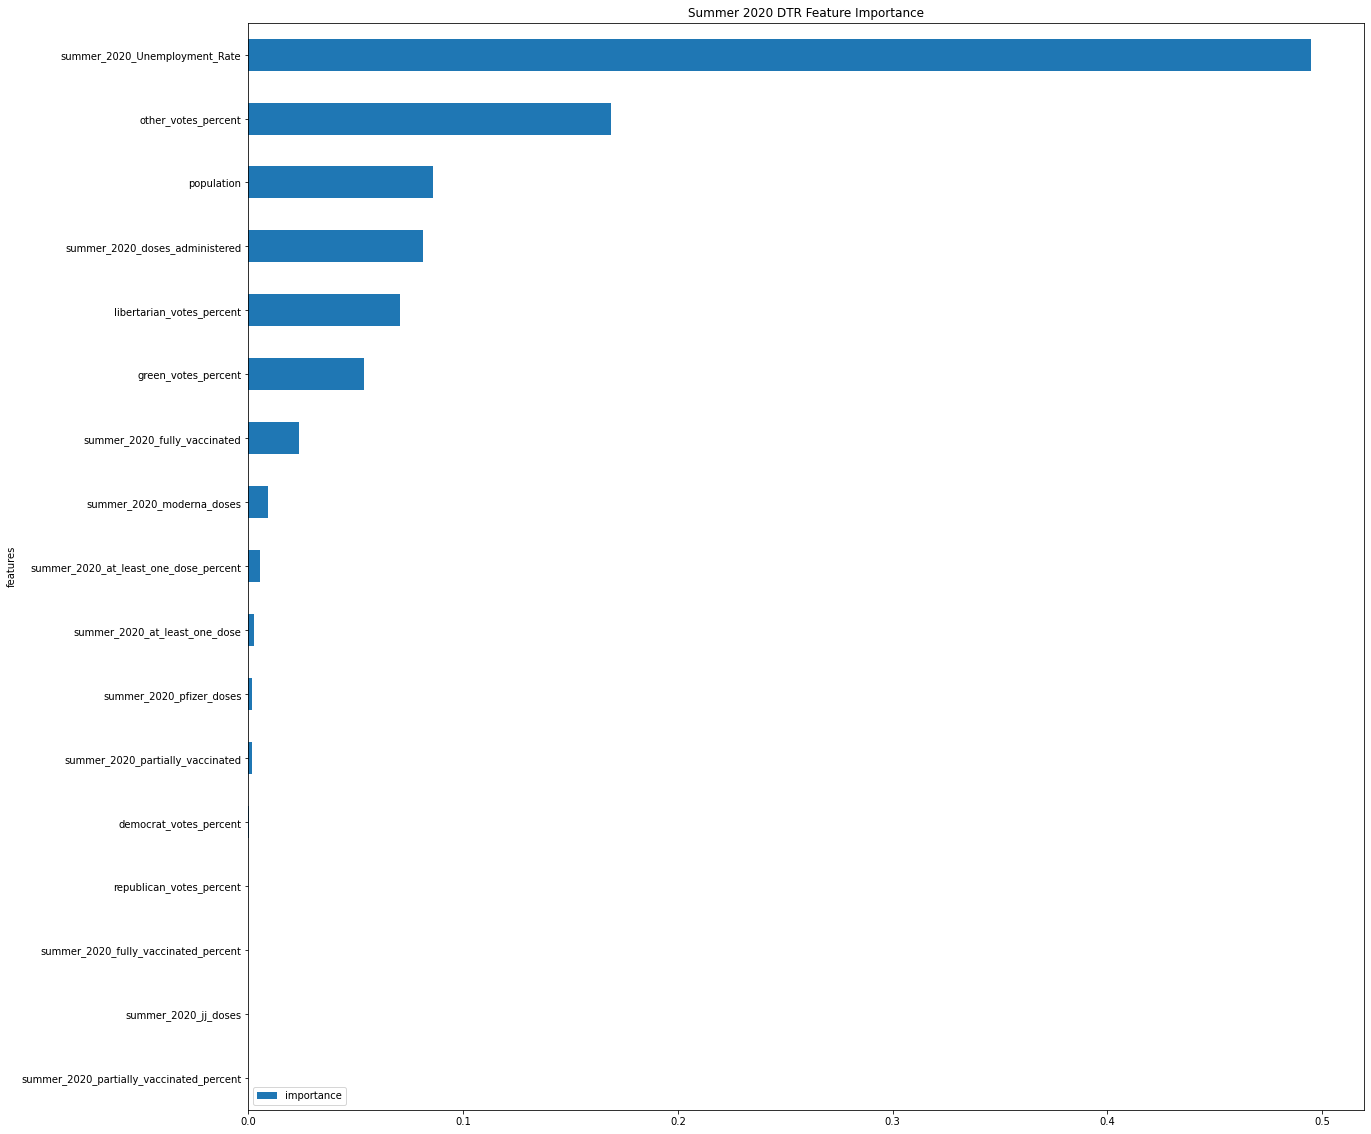

In [73]:
# add code that plots feature importances
importanceDF_summer2020.plot.barh(x='features', y='importance', figsize = (20,20), title = "Summer 2020 DTR Feature Importance")

Visualize Decision Tree

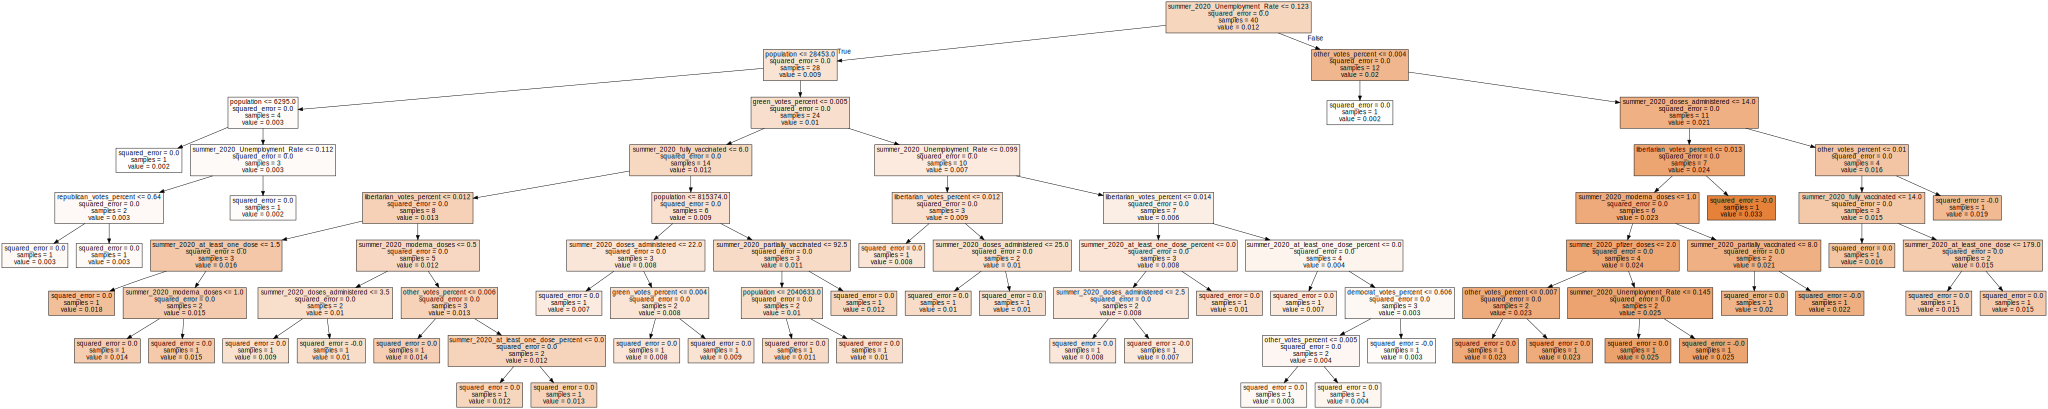

In [75]:
# Initialize tree data object 
dtr_summer2020_dot = tree.export_graphviz(dtr_summer2020, out_file=None, 
                                feature_names=features_summer2020.columns,  
                                filled=True)

# Draw graph
dtr_graph = graphviz.Source(dtr_summer2020_dot, format="png") 
dtr_graph

# Random Forest Regressor on Summer 2020 Data

Separating dataset into labels and features

In [76]:
labels_summer2020 = summer_2020['summer_2020_cases_per_capita']
features_summer2020 = summer_2020.drop(columns=['summer_2020_cases','summer_2020_cases_per_capita']) 

Splitting the dataset into training and testing data

In [77]:
features_train, features_test, labels_train, labels_test = train_test_split(features_summer2020, labels_summer2020, test_size=0.3, random_state=42) # 70% training and 30% test

Initializing and Training the Random Forest Regressor Model

In [78]:
rfr_summer2020 = RandomForestRegressor(n_estimators = 100, max_features = "auto", bootstrap = True, random_state = 42)
rfr_summer2020.fit(features_train, labels_train);

## Random Forest Errors

In [80]:
labels_pred = rfr_summer2020.predict(features_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(labels_test, labels_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(labels_test, labels_pred, squared=False))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(labels_test, labels_pred))

Mean Absolute Error (MAE): 0.003607740645748295
Mean Squared Error (MSE): 0.003962923494122509
Root Mean Squared Error (RMSE): 1.570476262026815e-05


## Random Forest Regressor Summer 2020 - Feature Importances

Initialize feature importances variable and store values into a dataframe to plot visually.

In [81]:
importance_summer2020 = rfr_summer2020.feature_importances_
# summarize feature importance
names_summer2020 = features_summer2020.columns.to_numpy(dtype=object)
importanceDF_summer2020 = pd.DataFrame({'features':names_summer2020, 'importance':importance_summer2020})

In [82]:
# sort from highest to lowest importance values
importanceDF_summer2020 = importanceDF_summer2020.sort_values(by=['importance'])

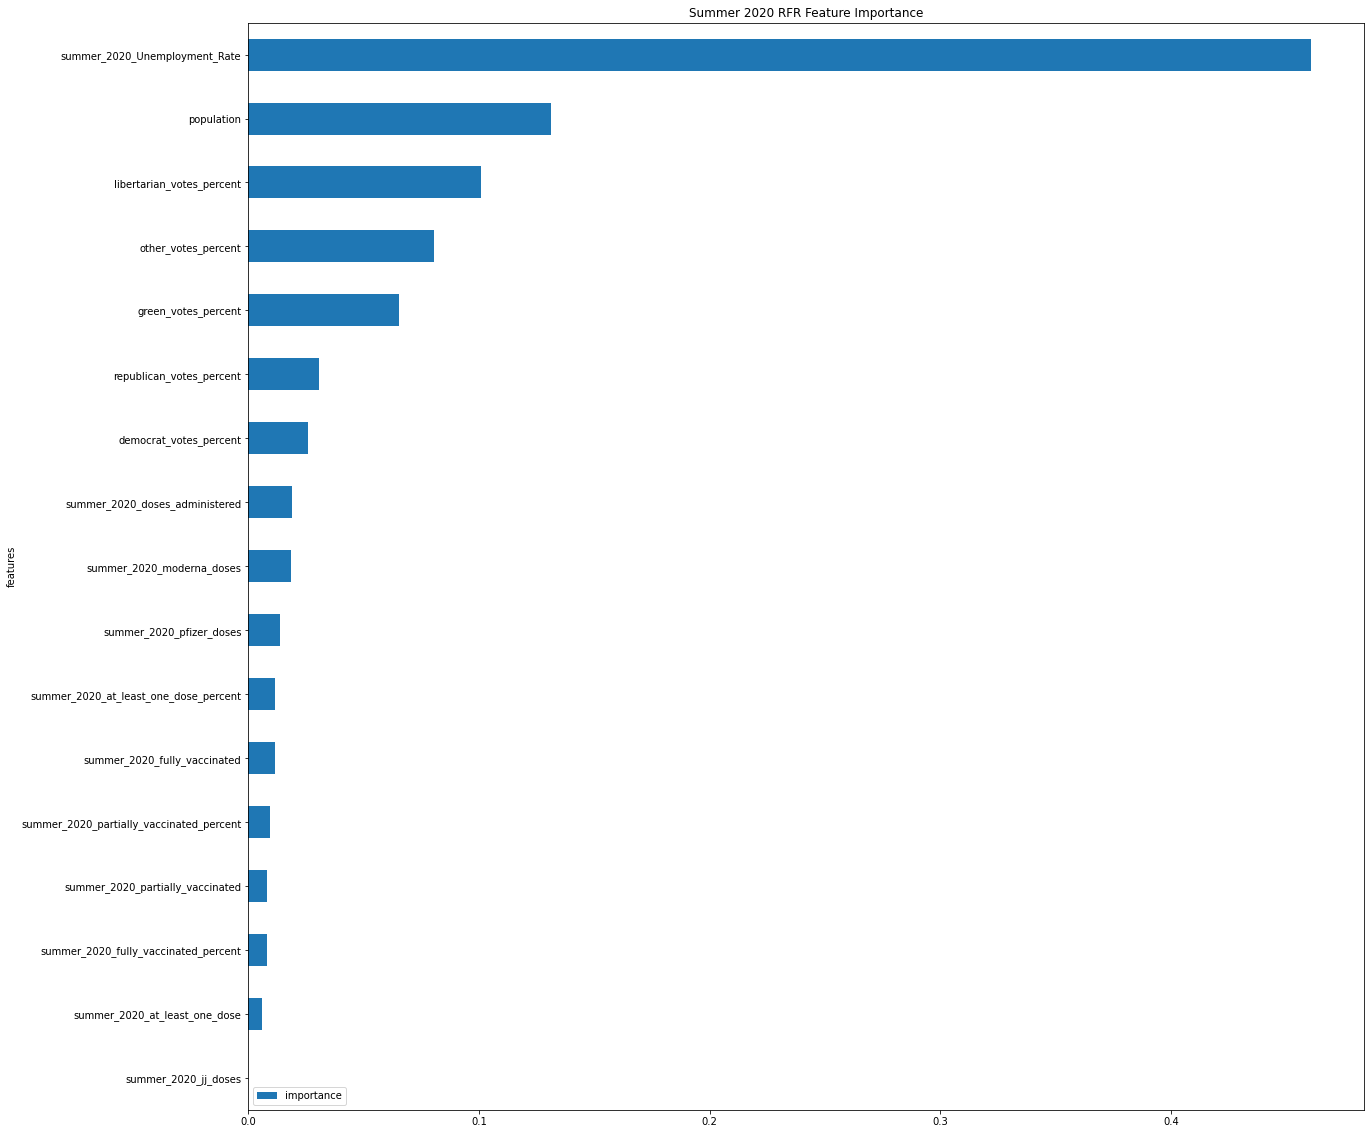

In [83]:
# plot using a bar graph
importanceDF_summer2020.plot.barh(x='features', y='importance', figsize = (20,20), title = "Summer 2020 RFR Feature Importance")

Visualize the first tree generated from the RF (estimator 0)

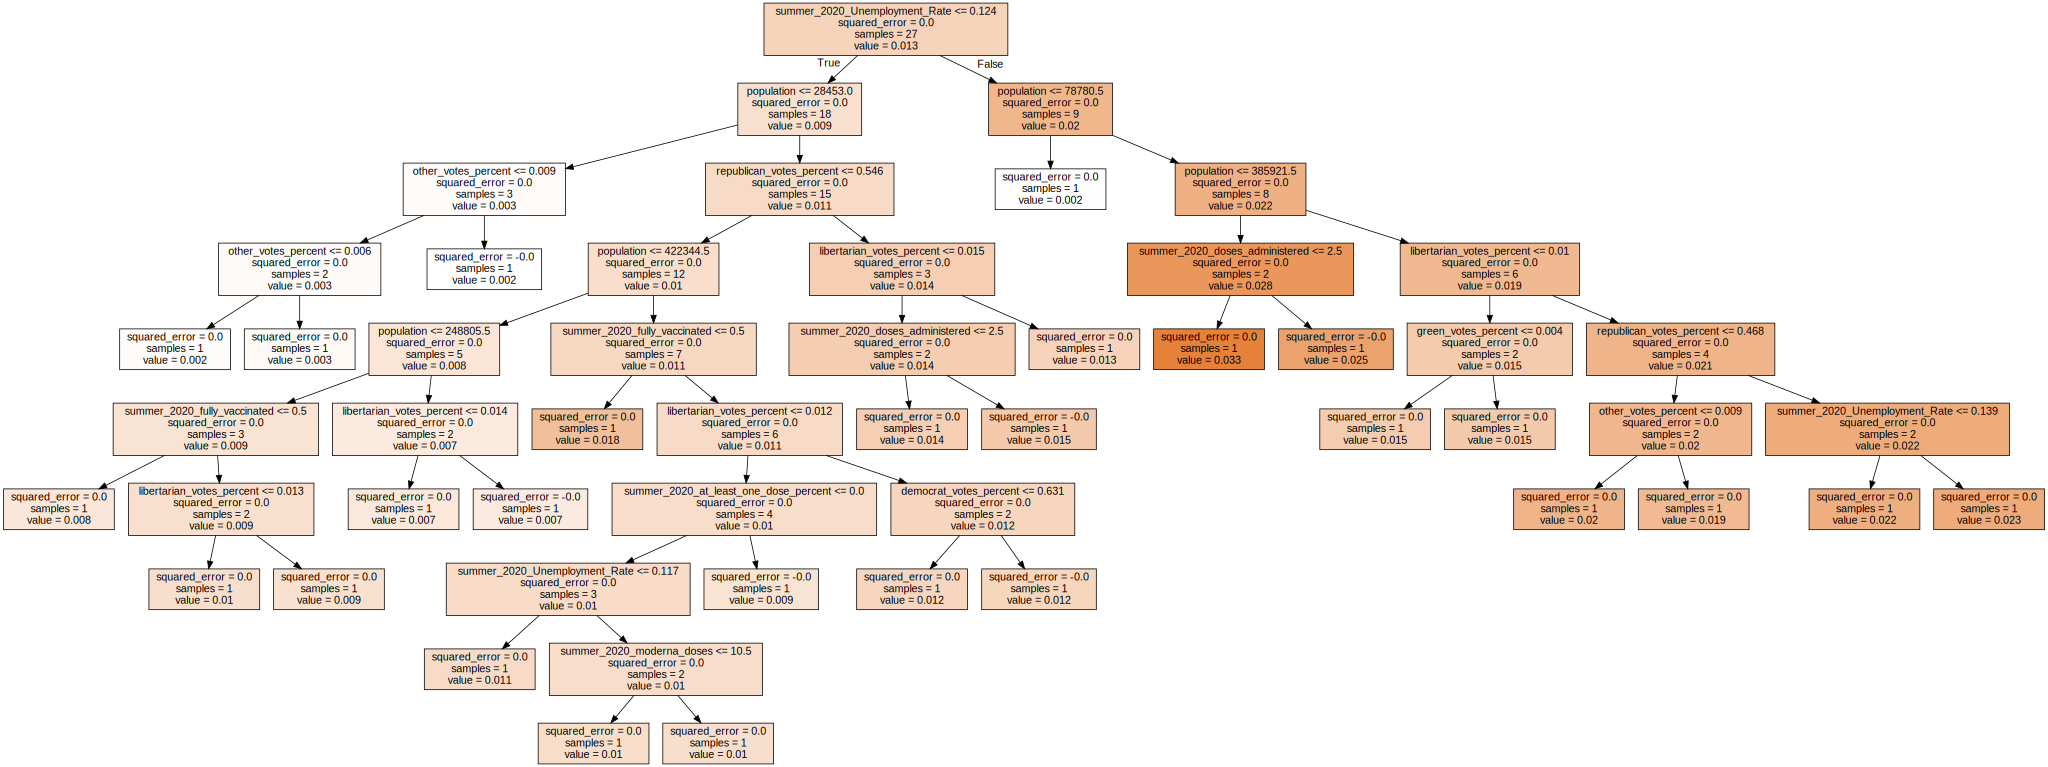

In [84]:
# Initialize tree data object 
rfr_summer2020_dot = tree.export_graphviz(rfr_summer2020.estimators_[0], out_file=None, 
                                feature_names=features_summer2020.columns,  
                                filled=True)

# Draw graph
rfr_summer2020_graph = graphviz.Source(rfr_summer2020_dot, format="png") 
rfr_summer2020_graph

## Assignment 3 - Looking at another tree

Instead of looking at the first tree generated, look at the last tree (99). Did you find any differences in the node contents?

[link text](https://)Assignment 3 Your Answer:           

Both models have the same feature importance
Green votes percent is lower in the RFR decision tree

# Gradient Boosting Regressor Tree on Summer 2020 Data

**Using XGBRegressor model**

XGBoost stands for "Extreme Gradient Boosting" and it is an implementation of gradient boosting trees algorithm. The XGBoost is a popular supervised machine learning model with characteristics like computation speed, parallelization, and performance. 


**Importing the model**

In [85]:
from xgboost import XGBRegressor

**Preparing the data**

Separate data into features and labels. Then we'll split them into the train and test parts. Here, We'll extract 30 percent of the dataset as test data.

In [86]:
feature_train, features_test, labels_train, labels_test=train_test_split(features_summer2020, labels_summer2020, test_size=0.30, random_state=42)


**Defining and fitting the model**

We'll use the XGBRegressor class of the xgboost package, and the parameters are defined as closed as the Random Forest Regression Model parameters. You can also set the new parameter values according to your data characteristics.

Defining the model

In [88]:
xgbr_summer2020 = xgb.XGBRegressor(n_estimators = 100, max_features = "auto", bootstrap = True, random_state = 42) 


Fitting the model with train data

In [89]:
xgbr_summer2020.fit(features_train,labels_train)

[21:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(bootstrap=True, max_features='auto', random_state=42)

## Boosted Tree Errors

In [94]:
labels_pred = xgbr_summer2020.predict(features_test)
xgbr_mae = metrics.mean_absolute_error(labels_test, labels_pred)
xgbr_mse = metrics.mean_squared_error(labels_test, labels_pred, squared=False)
xgbr_rmse = metrics.mean_squared_error(labels_test, labels_pred)
print('Mean Absolute Error (MAE):', xgbr_mae)
print('Mean Squared Error (MSE):', xgbr_mse)
print('Root Mean Squared Error (RMSE):', xgbr_rmse)

Mean Absolute Error (MAE): 0.004426778447162828
Mean Squared Error (MSE): 0.004967243072195147
Root Mean Squared Error (RMSE): 2.4673503738270686e-05


## Gradient Boosted Tree Regressor Summer 2020 - Feature Importances

In [91]:
xgbr_importance_summer2020 = xgbr_summer2020.feature_importances_
# summarize feature importance
xgbr_names_summer2020= features_summer2020.columns.to_numpy(dtype=object)
xgbr_importanceDF_summer2020 = pd.DataFrame({'features':xgbr_names_summer2020, 'importance':xgbr_importance_summer2020})

In [92]:
xgbr_importanceDF_summer2020 = xgbr_importanceDF_summer2020.sort_values(by=['importance'])

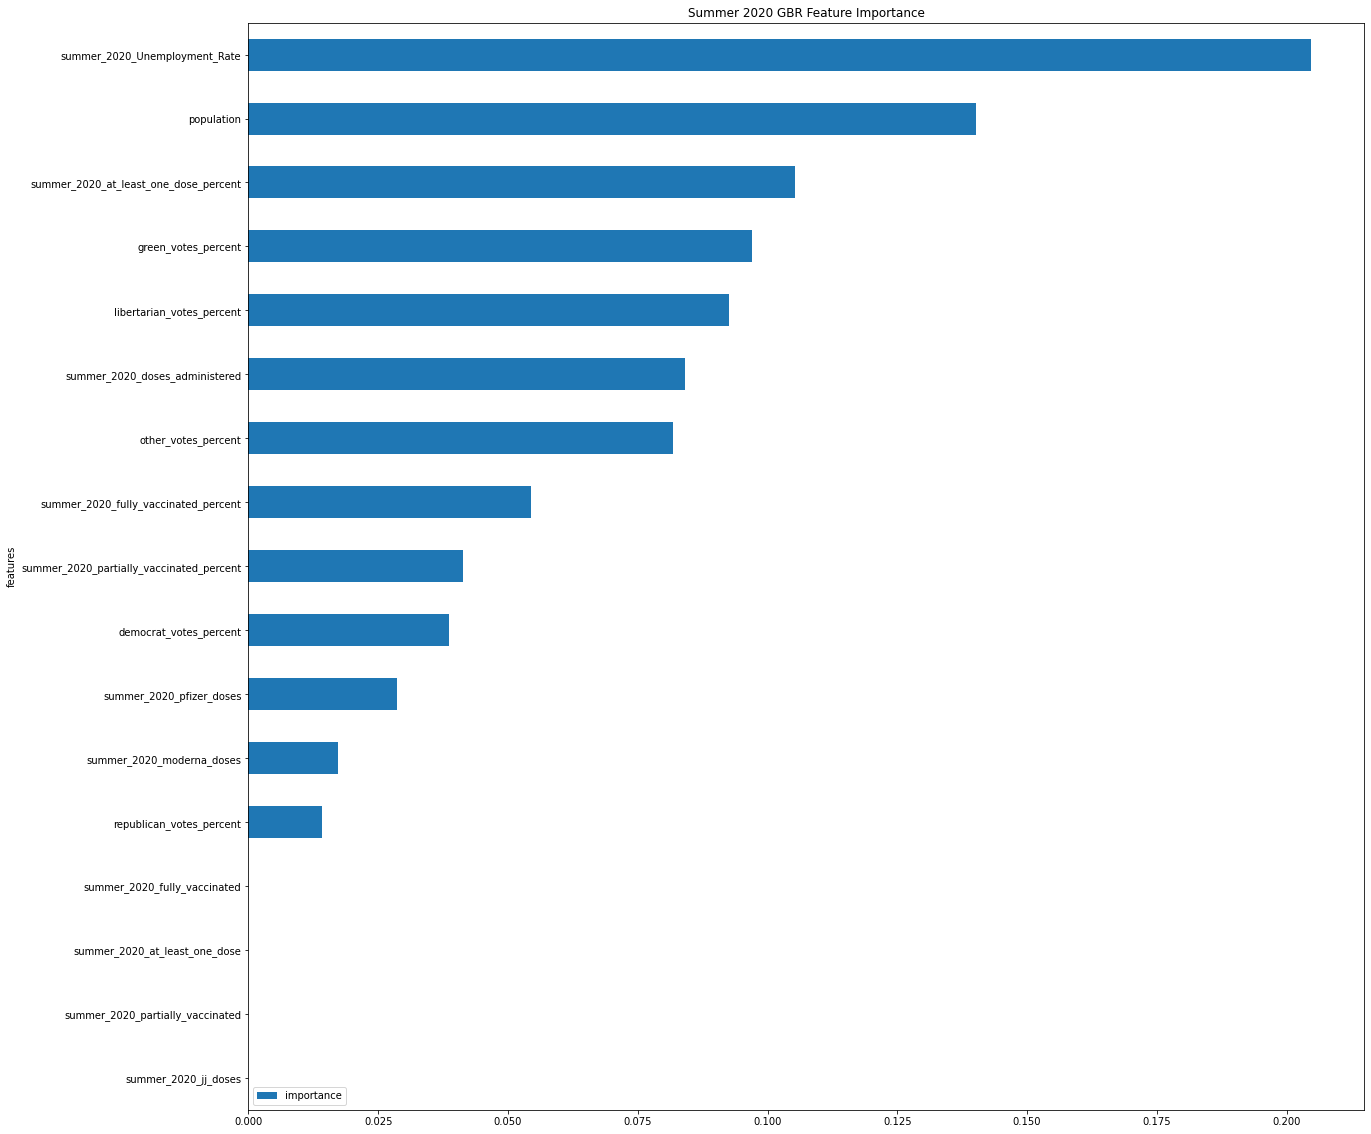

In [93]:
xgbr_importanceDF_summer2020.plot.barh(x='features', y='importance', figsize = (20,20), title = "Summer 2020 GBR Feature Importance")

In [ ]:
#DT
# Mean Absolute Error (MAE): 0.004213814566959224
# Mean Squared Error (MSE): 0.0049099039776417585
# Root Mean Squared Error (RMSE): 2.4107157069662362e-05

# RFR
# Mean Absolute Error (MAE): 0.003607740645748295
# Mean Squared Error (MSE): 0.003962923494122509
# Root Mean Squared Error (RMSE): 1.570476262026815e-05

#XGBR
# Mean Absolute Error (MAE): 0.004426778447162828
# Mean Squared Error (MSE): 0.004967243072195147
# Root Mean Squared Error (RMSE): 2.4673503738270686e-05

## Assignment 4 - Comparing feature importances and errors between the 3 models

In the text box below please note the 3 most important features for each model we trained using Summer 2020 data. Did you notice any differences or similarities?

Which model had the lowest MAE, MSE, and RMSE?

Decision Tree Regressor

1.   unemployment rate
2.   population
3.   libertarian votes percent



Random Forest Regressor

1.   unemployment rate
2.   population
3.   libertarian votes percent

Gradient Boosted Tree Regressor

1.   unemployment rate
2.   population
3.   summer_2020_atleast_one_dose_percent



*   Model with Lowest MAE - RF
*   Model with Lowest MSE - RF
*   Model with Lowest RMSE - RF



## Final Assignment - Create a Summer 2021 dataframe and model, to compare with the Summer 2020 models.

Using the code above for reference, make a dataframe for summer 2021 data.

Then choose one of the three models we covered in this notebook:                 


1.   Decision Tree
2.   Random Forest
3.   Gradient Boosted Trees

And train the model you chose on the summer 2021 dataframe you created.



In [95]:
# create a summer 2021 dataframe
summer_2021 = data.loc[:,data.columns.str.contains('county|population|summer_2021|democrat_votes_percent|green_votes_percent|republican_votes_percent|libertarian_votes_percent|other_votes_percent')]
summer_2021.head()

,county,population,summer_2021_cases,summer_2021_doses_administered,summer_2021_pfizer_doses,summer_2021_moderna_doses,summer_2021_jj_doses,summer_2021_partially_vaccinated,summer_2021_at_least_one_dose,summer_2021_fully_vaccinated,summer_2021_partially_vaccinated_percent,summer_2021_at_least_one_dose_percent,summer_2021_fully_vaccinated_percent,summer_2021_Unemployment_Rate,democrat_votes_percent,green_votes_percent,republican_votes_percent,libertarian_votes_percent,other_votes_percent
0,Alameda,1685886,23141,258266,204507,44793,8898,101159,109907,115788,0.055480,0.765296,0.717004,0.064572,0.802082,0.006057,0.177009,0.008175,0.006679
1,Alpine,1117,13,72,10,62,0,22,22,7,0.085366,0.691638,0.606272,0.085106,0.642375,0.005398,0.329285,0.020243,0.002699
2,Amador,38531,1319,4960,2686,1875,399,2266,2673,2199,0.088794,0.570673,0.488170,0.067485,0.365540,0.004932,0.609084,0.015647,0.004797
3,Butte,217769,6060,33097,23097,8394,1606,14914,16492,15069,0.055096,0.492463,0.442633,0.070815,0.494053,0.004967,0.477436,0.017381,0.006163
4,Calaveras,44289,1392,6594,3804,2420,370,3079,3449,2854,0.061501,0.538256,0.481066,0.057351,0.369828,0.004602,0.608084,0.013216,0.004270


In [96]:
# drop the county column 
summer_2021 = summer_2021.drop(columns=['county'])

In [99]:
# creat a case per capita column (summer_2021_cases/population)
summer_2021['summer_2021_cases_per_capita'] = summer_2021["summer_2021_cases"]/summer_2021["population"]

In [101]:
summer_2021.columns

Index(['population', 'summer_2021_cases', 'summer_2021_doses_administered',
       'summer_2021_pfizer_doses', 'summer_2021_moderna_doses',
       'summer_2021_jj_doses', 'summer_2021_partially_vaccinated',
       'summer_2021_at_least_one_dose', 'summer_2021_fully_vaccinated',
       'summer_2021_partially_vaccinated_percent',
       'summer_2021_at_least_one_dose_percent',
       'summer_2021_fully_vaccinated_percent', 'summer_2021_Unemployment_Rate',
       'democrat_votes_percent', 'green_votes_percent',
       'republican_votes_percent', 'libertarian_votes_percent',
       'other_votes_percent', 'summer_2021_cases_per_capita'],
      dtype='object')

In [114]:
# separate into labels and features
labels_summer2021 = summer_2021['summer_2021_cases_per_capita']
features_summer2021 = summer_2021.drop(columns=['summer_2021_cases_per_capita','summer_2021_cases']) 

In [116]:
# split into training and testing datasets
features_train, features_test, labels_train, labels_test=train_test_split(features_summer2021, labels_summer2021, test_size=0.30, random_state=42)

In [117]:
# initialize and train one of the three models
rfr_summer2021 = RandomForestRegressor(n_estimators = 100, max_features = "auto", bootstrap = True, random_state = 42)
rfr_summer2021.fit(feature_train, labels_train);

In [118]:
# plot feature importances
labels_pred = rfr_summer2021.predict(features_test)

In [120]:
labels_pred = rfr_summer2021.predict(features_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(labels_test, labels_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(labels_test, labels_pred, squared=False))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(labels_test, labels_pred))

Mean Absolute Error (MAE): 0.006539557657356476
Mean Squared Error (MSE): 0.009570695646400389
Root Mean Squared Error (RMSE): 9.159821515602735e-05


In [121]:
importance_summer2021 = rfr_summer2021.feature_importances_
# summarize feature importance
names_summer2021 = features_summer2021.columns.to_numpy(dtype=object)
importanceDF_summer2021 = pd.DataFrame({'features':names_summer2021, 'importance':importance_summer2021})

In [122]:
# sort from highest to lowest importance values
importanceDF_summer2021 = importanceDF_summer2021.sort_values(by=['importance'])

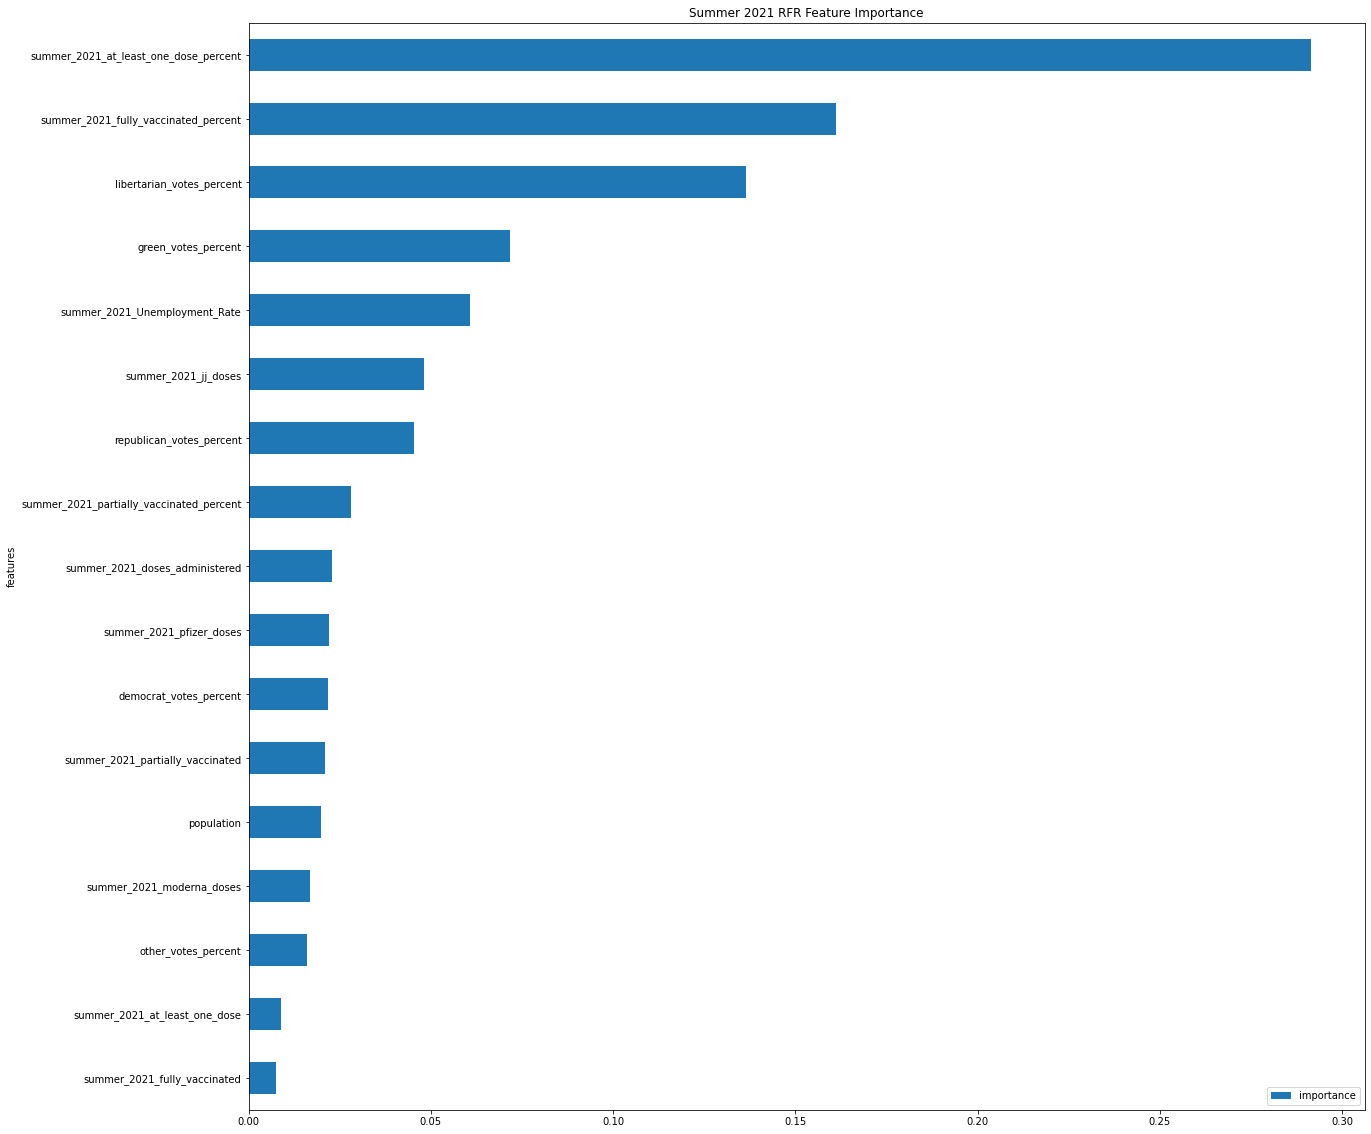

In [125]:
importanceDF_summer2021.plot.barh(x='features', y='importance', figsize = (20,20), title = "Summer 2021 RFR Feature Importance")

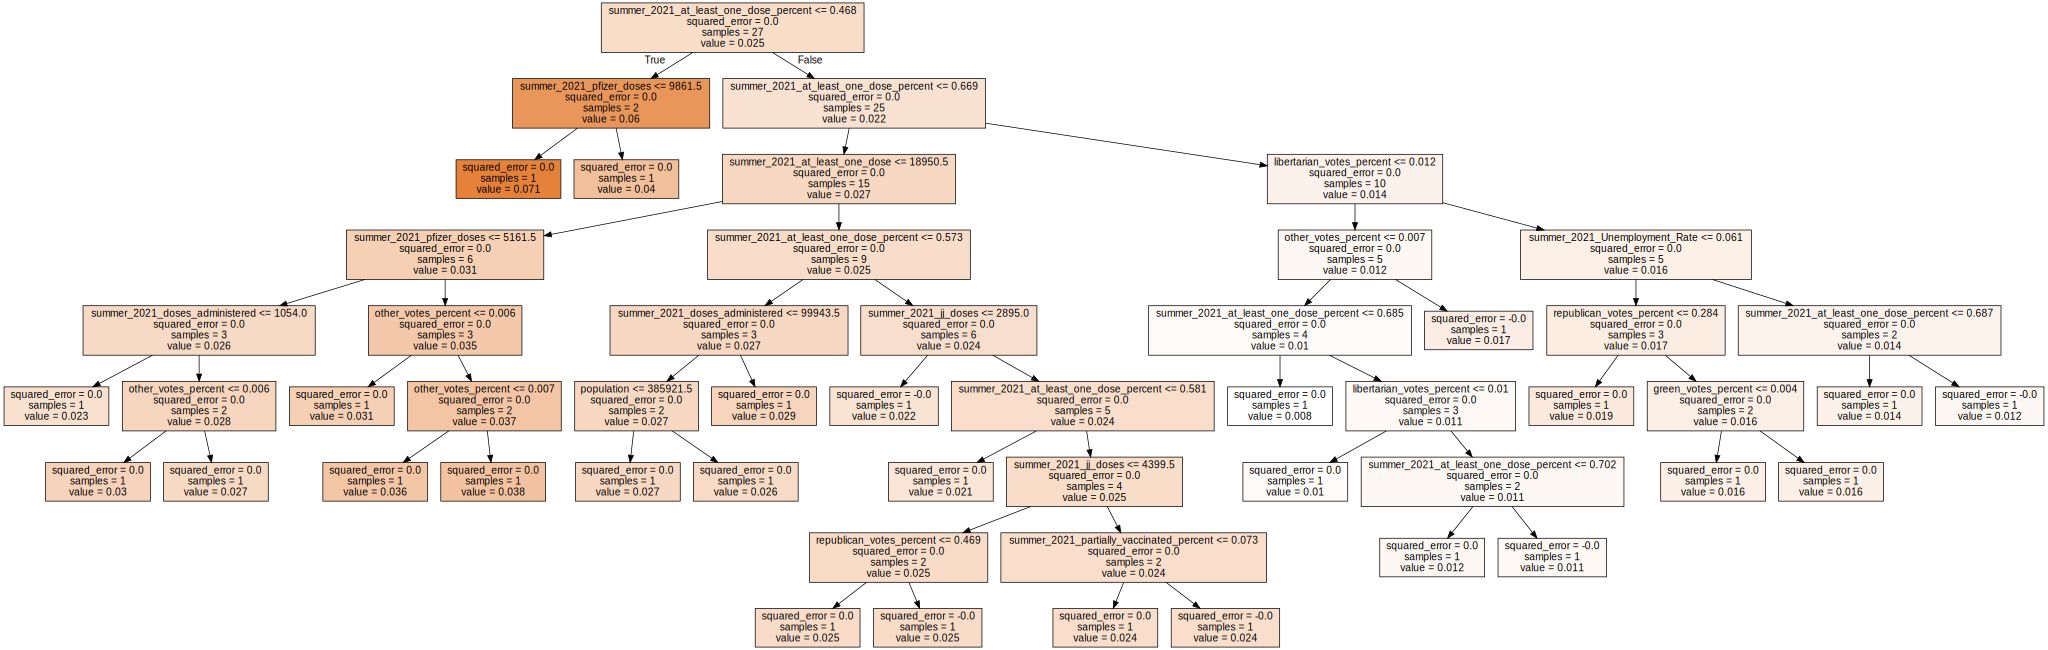

In [124]:
# Initialize tree data object 
rfr_summer2021_dot = tree.export_graphviz(rfr_summer2021.estimators_[0], out_file=None, 
                                feature_names=features_summer2021.columns,  
                                filled=True)

# Draw graph
rfr_summer2021_graph = graphviz.Source(rfr_summer2021_dot, format="png") 
rfr_summer2021_graph

Did you see any significant differences in feature importances between the model you trained vs the 2020 version?

Your Answer: 
Summer 2021 has "atleast one dose" as the highest feature
Second highest feature was fully vaccinated percent

Summer 2020 had unemployment rate and population as the top two features. 